In [32]:
import numpy as np
import pandas as pd
import heaan
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

## Encrypted SVM model

In [33]:
class SVM:

    def __init__(self, learning_rate, lambda_param, n_iters, encryptor, enc_key, eval, keypack, decryptor, secret_key):
        self.lr = learning_rate
        self.lambda_param = lambda_param
        self.n_iters = n_iters
        self.encryptor = encryptor
        self.enc_key = enc_key
        self.eval = eval
        self.keypack = keypack
        self.decryptor = decryptor
        self.secret_key = secret_key
        self.w = None
        self.b = None
        self.idx = 0

    def Myadd(self, a, b):
        result = heaan.Ciphertext()
        self.eval.add(a, b, result)

        return result

    def Mysub(self, a, b):
        result = heaan.Ciphertext()
        if type(a) is np.float64 or type(a) is int:
            a = heaan.Message([a])
            ctxt = heaan.Ciphertext()
            self.encryptor.encrypt(a, self.enc_key, ctxt)
            self.eval.sub(ctxt, b, result)
        # elif type(b) is np.float64:
        else:
            self.eval.sub(a, b, result)

        return result

    def matrix_sub(self, a, b):
        result_matrix = []
        for i in range(len(a)):
            result_matrix.append(self.Mysub(a[i], b[i]))
        # result_matrix.append(self.Mysub(a[0], b[0]))
        # result_matrix.append(self.Mysub(a[1], b[1]))

        return result_matrix

    def enc_multi(self, a, b):
        # both a&b are encrypted
        result = heaan.Ciphertext()
        self.eval.mult(a, b, self.keypack, result)

        return result

    def num_multi(self, a, b):
        # b is real number
        result = heaan.Ciphertext()
        self.eval.mult(a, b, result)
#         if result.get_level() < 7:
#             self.eval.bootstrap(result, self.keypack, result)

        return result

    def num_matrix_multi(self, a, b):
        # a is a number, b is an encrypted matrix
        # [a * b[0], a * b[1]]
        result_matrix = []
        if type(b) is np.ndarray:
            # test = []
            mess = []
            ctxt = []
            for i in range(len(b)):
                mess.append(heaan.Message([b[i]]))
                ctxt.append(heaan.Ciphertext())
                self.encryptor.encrypt(mess[i], self.enc_key, ctxt[i])
                result_matrix.append(self.num_multi(ctxt[i], a))
            # a = heaan.Message([b[0]])
            # b = heaan.Message([b[1]])
            # ctxt = heaan.Ciphertext()
            # ctxt_ = heaan.Ciphertext()
            # self.encryptor.encrypt(a, self.enc_key, ctxt)
            # self.encryptor.encrypt(b, self.enc_key, ctxt_)
            # test.append(ctxt)
            # test.append(ctxt_)
            # result_matrix.append(self.num_multi(test[0], a))
            # result_matrix.append(self.num_multi(test[1], a))
        elif type(a) is float:
            for i in range(len(b)):
                result_matrix.append(self.num_multi(b[i], a))
                # result_matrix.append(self.num_multi(b[1], a))
        else:
            for i in range(len(b)):
                result_matrix.append(self.enc_multi(b[i], a))
                # result_matrix.append(self.enc_multi(b[1], a))

        return result_matrix

    def enc_n_power(self, x, n):
        arr = []
        a = heaan.Message([1])
        ctxt = heaan.Ciphertext()
        self.encryptor.encrypt(a, self.enc_key, ctxt)
        if n == 0:
            return ctxt
        elif n == 1:
            return x
        else:
            b = heaan.Message([1])
            result = heaan.Ciphertext()
            self.encryptor.encrypt(b, self.enc_key, result)

            if n % 2 == 0:
                for i in range(int(n/2)):
                    arr.append(heaan.Ciphertext())
                    arr[i] = self.enc_multi(x, x)
                    result = self.enc_multi(self.enc_multi(ctxt, arr[i]), result)
                    if result.get_level() < 10:
                        self.eval.bootstrap(result, self.keypack, result)
                    # print(result)

                return result
            else:
                for i in range(int((n-1)/2)):
                    arr.append(heaan.Ciphertext())
                    arr[i] = self.enc_multi(x, x)
                    result = self.enc_multi(self.enc_multi(ctxt, arr[i]), result)
                    if result.get_level() < 10:
                        self.eval.bootstrap(result, self.keypack, result)
                    # print(result)

                return self.enc_multi(result, x)

    def dec(self, a):
        dmsg = heaan.Message()
        self.decryptor.decrypt(a, self.secret_key, dmsg)

        return dmsg

    def dec_arr(self, arr):
        result = []
        mess = []
        for i in range(len(arr)):
            mess.append(heaan.Message())
            self.decryptor.decrypt(arr[i], self.secret_key, mess[i])
            result.append(mess[i])
        # d_1 = heaan.Message()
        # d_2 = heaan.Message()
        # self.decryptor.decrypt(arr[0], self.secret_key, d_1)
        # result.append(d_1)
        # self.decryptor.decrypt(arr[1], self.secret_key, d_2)
        # result.append(d_2)

        return result

    def factorial(self, m, n):
        denominator = 1
        molecular = 1

        for x in range(1, m + 1):
            denominator *= x

        for y in range(1, n + 1):
            molecular *= y

        return denominator / (molecular * molecular)

    def sgn(self, x):
        flag = heaan.Message([0])
        f = heaan.Ciphertext()
        self.encryptor.encrypt(flag, self.enc_key, f)
        for i in range(0, 500):
            v_1 = 1 / (4 ** i) * self.factorial(2 * i, i)
            v_2 = self.Mysub(1, self.enc_multi(x, x))
            if v_2.get_level() < 6:
                self.eval.bootstrap(v_2, self.keypack, v_2)
            # print(self.dec(v_2))
            v_3 = self.enc_n_power(v_2, i)
            if v_3.get_level() < 6:
                self.eval.bootstrap(v_3, self.keypack, v_3)
            # print(self.dec(v_3))
            v_4 = self.enc_multi(v_3, x)
            if v_4.get_level() < 6:
                self.eval.bootstrap(v_4, self.keypack, v_4)
            # print(self.dec(v_4))
            # v_2 = self.enc_multi(self.enc_n_power(self.Mysub(1, self.enc_multi(x, x)), i), x)
            f = self.Myadd(self.num_multi(v_4, v_1), f)
            if f.get_level() < 6:
                self.eval.bootstrap(f, self.keypack, f)
            # print(self.dec(f))
            # f += 1 / (4 ** i) * self.factorial(2 * i, i) * x * (1 - x ** 2) ** i
            # print(f)

        return f

    def d_muti(self, a, b):
        # b_0 = heaan.Message([b[0]])
        # b_1 = heaan.Message([b[1]])
        # encb_0 = heaan.Ciphertext()
        # encb_1 = heaan.Ciphertext()
        # self.encryptor.encrypt(b_0, self.enc_key, encb_0)
        # self.encryptor.encrypt(b_1, self.enc_key, encb_1)

        # multi
        if type(b) is np.ndarray:
            ctxt_mult = []
            for i in range(len(a)):
                ctxt_mult.append(heaan.Ciphertext())
                self.eval.mult(a[i], b[i], ctxt_mult[i])
            # ctxt_mult_1 = heaan.Ciphertext()
            # ctxt_mult_2 = heaan.Ciphertext()
            # self.eval.mult(a[0], b[0], ctxt_mult_1)
            # self.eval.mult(a[1], b[1], ctxt_mult_2)

            # add
            a = heaan.Message([0])
            ctxt_add = heaan.Ciphertext()
            self.encryptor.encrypt(a, self.enc_key, ctxt_add)
            for i in ctxt_mult:
                ctxt_add = self.Myadd(i, ctxt_add)

            return ctxt_add
        else:
            ctxt_mult = []
            for i in range(len(a)):
                ctxt_mult.append(heaan.Ciphertext())
                self.eval.mult(a[i], b[i],  self.keypack, ctxt_mult[i])
            # ctxt_mult_1 = heaan.Ciphertext()
            # ctxt_mult_2 = heaan.Ciphertext()
            # self.eval.mult(a[0], b[0], self.keypack, ctxt_mult_1)
            # self.eval.mult(a[1], b[1], self.keypack, ctxt_mult_2)

            a = heaan.Message([0])
            ctxt_add = heaan.Ciphertext()
            self.encryptor.encrypt(a, self.enc_key, ctxt_add)
            for i in ctxt_mult:
                ctxt_add = self.Myadd(i, ctxt_add)

            return ctxt_add

    def fit(self, X, y):
        y_ = y
        length = len(X[0])
        # n_samples, n_features = X.shape
        self.w = np.zeros(length)
        self.b = 0

        for _ in range(self.n_iters):
            self.idx = 0
            for x_i in X:
                # print(self.dec_arr(x_i))
                dot = self.d_muti(x_i, self.w)
                su = self.Mysub(dot, self.b)
                condition = self.enc_multi(y_[self.idx], su)
                condition_dec = self.dec(condition)
                flag = float(np.array(condition_dec).real) >= 1
                # flag = True
                if flag:
                    v_5 = self.num_matrix_multi(self.lr * 2 * self.lambda_param, self.w)
                    self.w = self.matrix_sub(self.w, v_5)
                    # print('True w: ', self.w)
                    for i in range(length):
                        if self.w[i].get_level() < 17:
                            self.eval.bootstrap(self.w[i], self.keypack, self.w[i])
                    # print(self.w)
                    # self.w -= self.lr * (2 * self.lambda_param * self.w)
                else:
                    v_1 = self.num_matrix_multi(2 * self.lambda_param, self.w)
                    # print('v_1: ', self.dec_arr(v_1))
                    v_2 = self.num_matrix_multi(y_[self.idx], x_i)
                    # print('v_2: ', self.dec_arr(v_2))
                    v_3 = self.matrix_sub(v_1, v_2)
                    # print('v_3: ', self.dec_arr(v_3))
                    v_4 = self.num_matrix_multi(self.lr, v_3)
                    # print('v_4: ', self.dec_arr(v_4))
                    self.w = self.matrix_sub(self.w, v_4)
                    # print('w: ', self.dec_arr(self.w))
                    # print(self.dec(self.w))
                    b_old = self.num_multi(y_[self.idx], self.lr)
                    self.b = self.Mysub(self.b, b_old)
                    # print(self.dec(self.b))
                    for i in range(length):
                        if self.w[i].get_level() < 17:
                            self.eval.bootstrap(self.w[i], self.keypack, self.w[i])
                    # print(self.w)
                    # print(self.b)

                self.idx += 1

    def predict(self, X):
        # linear_output = np.dot(X, self.w) - self.b
        v_1 = self.d_muti(self.w, X)
        # print('v_1: ', self.dec(v_1))
        v_2 = self.Mysub(v_1, self.b)
        # print('v_2: ', self.dec(v_2))
        # linear_output = self.Mysub(self.d_muti(self.w, X), self.b)
        # if result > 0: return 1, otherwise return 0
        return v_2

    
def MyAdd(a, b, eval):
    add_ctxt = heaan.Ciphertext()
    eval.add(a, b, add_ctxt)

    return add_ctxt


def MyMulti(a, b, keypack, eval):
    multi_ctxt = heaan.Ciphertext()
    eval.mult(a, b, keypack, multi_ctxt)

    return multi_ctxt


def MySub(a, b, eval):
    sub_ctxt = heaan.Ciphertext()
    eval.sub(a, b, sub_ctxt)

    return sub_ctxt


def MyNegate(a, eval):
    neg_ctxt = heaan.Ciphertext()
    eval.negate(a, neg_ctxt)

    return neg_ctxt


def Inverse(x, eval, encryptor, enc_key, keypack, d):
    # 0<x<2
    a0 = heaan.Ciphertext()
    b0 = heaan.Ciphertext()

    msg = heaan.Message([2])
    ctxt = heaan.Ciphertext()
    encryptor.encrypt(msg, enc_key, ctxt)
    msg_ = heaan.Message([1])
    ctxt_ = heaan.Ciphertext()
    encryptor.encrypt(msg_, enc_key, ctxt_)
    eval.sub(ctxt, x, a0)
    eval.sub(ctxt_, x, b0)
    a = [a0]
    b = [b0]
    for i in range(1, d):
        f = heaan.Ciphertext()
        a.append(f)
        b.append(f)

    for i in range(d-1):
        if a[i].get_level() < 17 or b[i].get_level() < 17:
            eval.bootstrap(a[i], keypack, a[i])
            eval.bootstrap(b[i], keypack, b[i])

        b[i+1] = MyMulti(b[i], b[i], keypack, eval)
        # add_ctxt = heaan.Ciphertext()
        a[i+1] = MyMulti(a[i], MyAdd(ctxt_, b[i+1], eval), keypack, eval)

    return a[d-1]


def Sqrt(x, eval, encryptor, enc_key, keypack, d):
    # 0<=x<=1
    b0 = heaan.Ciphertext()

    tag1 = heaan.Message([1/2])
    ctxt_tag1 = heaan.Ciphertext()
    encryptor.encrypt(tag1, enc_key, ctxt_tag1)

    tag2 = heaan.Message([1/4])
    ctxt_tag2 = heaan.Ciphertext()
    encryptor.encrypt(tag2, enc_key, ctxt_tag2)

    tag2 = heaan.Message([3])
    ctxt_tag3 = heaan.Ciphertext()
    encryptor.encrypt(tag2, enc_key, ctxt_tag3)

    msg_ = heaan.Message([1])
    ctxt_ = heaan.Ciphertext()
    encryptor.encrypt(msg_, enc_key, ctxt_)

    eval.sub(x, ctxt_, b0)
    a = [x]
    b = [b0]
    for i in range(1, d):
        f = heaan.Ciphertext()
        a.append(f)
        b.append(f)

    for i in range(d-1):
        if a[i].get_level() < 17 or b[i].get_level() < 17:
            eval.bootstrap(a[i], keypack, a[i])
            eval.bootstrap(b[i], keypack, b[i])

        bridge_a = MyAdd(MyNegate(MyMulti(b[i], ctxt_tag1, keypack, eval), eval), ctxt_, eval)
        a[i+1] = MyMulti(a[i], bridge_a, keypack, eval)
        bridge_b = MyMulti(MySub(b[i], ctxt_tag3, eval), ctxt_tag2, keypack, eval)
        power_b = MyMulti(b[i], b[i], keypack, eval)
        b[i+1] = MyMulti(power_b, bridge_b, keypack, eval)

    return a[d-1]


def Max(a, b, encryptor, enc_key, keypack, eval):
    tag1 = heaan.Message([1 / 2])
    ctxt_tag1 = heaan.Ciphertext()
    encryptor.encrypt(tag1, enc_key, ctxt_tag1)

    # x = heaan.Ciphertext()
    # y = heaan.Ciphertext()

    x = MyMulti(MyAdd(a, b, eval), ctxt_tag1, keypack, eval)
    y = MyMulti(MySub(a, b, eval), ctxt_tag1, keypack, eval)
    power_y = MyMulti(y, y, keypack, eval)
    z = Sqrt(power_y, eval, encryptor, enc_key, keypack, 100)

    return MyAdd(x, z, eval)

def encNum(data, context, enc_key):
    message = heaan.Message([data])
    encryptor = heaan.Encryptor(context)
    ciphertext = heaan.Ciphertext()
    encryptor.encrypt(message, enc_key, ciphertext)

    return ciphertext


def encMess(message, context, enc_key):
    ciphertext = heaan.Ciphertext()
    encryptor = heaan.Encryptor(context)
    encryptor.encrypt(message, enc_key, ciphertext)

    return ciphertext


def data_enc(X, label, enc_key, encryptor, context):
    # encrypt label
    mess = []
    ciphertext_label = []
    num = [[0] * X.shape[1] for x in range(len(label))]
    ciphertext_data = [[heaan.Ciphertext()] * X.shape[1] for x in range(len(label))]
    count = 0
    c = 0

    # i = 0

    for ele in label:
        mess.append(heaan.Message([ele]))
        ciphertext_label.append(heaan.Ciphertext())

    if len(label) > 0:
        a = len(label)
        for l in range(a):
            encryptor.encrypt(mess[l], enc_key, ciphertext_label[l])

    for i in X:
        for j in range(X.shape[1]):
            num[count][j] = heaan.Message([i[j]])
        count += 1
            # num[count][1] = heaan.Message([i[1]])
        # encryptor.encrypt(num[count][0], enc_key, ciphertext_data[count][0])
        # encryptor.encrypt(num[count][1], enc_key, ciphertext_data[count][1])

    for _ in range(len(num)):
        # encryptor.encrypt(num[c][0], enc_key, ciphertext_data[c][0])
        # encryptor.encrypt(num[c][1], enc_key, ciphertext_data[c][1])
        for i in range(X.shape[1]):
            ciphertext_data[c][i] = encMess(num[c][i], context, enc_key)
            # ciphertext_data[c][1] = encMess(num[c][1], context, enc_key)
        c += 1

    return ciphertext_data, ciphertext_label


def dec(arr, decryptor, secret_key):
    result = []
    d_1 = heaan.Message()
    d_2 = heaan.Message()
    decryptor.decrypt(arr[0], secret_key, d_1)
    result.append(d_1)
    decryptor.decrypt(arr[1], secret_key, d_2)
    result.append(d_2)

    return result


def dec_arr(arr, decryptor, secret_key):
    result = []
    for i in arr:
        d = heaan.Message()
        decryptor.decrypt(i, secret_key, d)
        result.append(d)

    return result


def dec_arr_(arr, decryptor, secret_key):
    result = []
    for i in arr:
        d = heaan.Message()
        decryptor.decrypt(i, secret_key, d)
        result.append(d)
    
    pre_ = []
#     for i in result:
#         if float(np.array(i))> 0.9 and float(np.array(i)) <= 1.1:
#             pre_.append(1)
#         elif float(np.array(i))>= -1.1 and float(np.array(i)) < -0.9:
#             pre_.append(0)
#         elif float(np.array(i))> 1.1:
#             pre_.append(0)
#         else:
#             pre_.append(1)
    for i in result:
        if float(np.array(i)) > 0:
            pre_.append(1)
        else:
            pre_.append(0)

    return pre_


def d(a, decryptor, secret_key):
    d_2 = heaan.Message()
    decryptor.decrypt(a, secret_key, d_2)

    return d_2


def pred(model, data):
    result = []
    for i in data:
        output = model.predict(i)
        result.append(output)

    return result

## Data preparation

In [34]:
def data_pre():
    data = pd.read_csv('/Users/xialetian/Downloads/Iriss.csv')
    columns = data.columns.values
    le_species = LabelEncoder()
    data['label'] = le_species.fit_transform(data[columns[5]])
    data = data.drop(columns[5], axis='columns')
    data = data.drop(columns[0], axis='columns')
    data = data.iloc[:100, :]
    y = data['label'].to_numpy()
    X = data.loc[:, data.columns != 'label'].to_numpy()
    train_data, test_data, train_label, test_label = train_test_split(X,y)
    
    return train_data, test_data, train_label, test_label

## Preparation before encryption

- context
- secret_key
- encryptor
- evaluator
- keypack/public_key/enc_key
- decryptor

In [35]:
params = heaan.Parameters()
log_slots = 16
context = heaan.Context(params)
context.make_bootstrappable(log_slots)
key_dir_path = "venv/keys"
secret_key = heaan.SecretKey(context)
keypack = heaan.PublicKeyPack(context, secret_key, key_dir_path)
eval = heaan.HomEvaluator(context)
encryptor = heaan.Encryptor(context)
enc_key = keypack.get_enc_key()
decryptor = heaan.Decryptor(context)

data_train, data_test, label_train, label_test = data_pre()
# min_max_scaler = preprocessing.MinMaxScaler()
# X_train_minmax = min_max_scaler.fit_transform(data_train)
# X_test_minmax = min_max_scaler.fit_transform(data_test)
label = np.where(label_train <= 0, -1, 1)
X = data_train
    # print(X, label_train)
    # for idx, x_i in enumerate(X):
    #     print(type(x_i))

## Encrypted data/label & Model training

In [36]:
# ····················· Model Training ·························
clf = SVM(0.0001, 0.01, 10000, encryptor, enc_key, eval, keypack, decryptor, secret_key)
enc_data, enc_label = data_enc(X, label, enc_key, encryptor, context)
# print(enc_data)
# print(enc_label)
print('····················· Model Training ·························')
clf.fit(enc_data, enc_label)
print('Enc w: ', clf.w)
print('Enc b: ', clf.b)
print('w: ', dec_arr(clf.w, decryptor, secret_key))
print('b: ', d(clf.b, decryptor, secret_key))
print('-----------------------------------------------------------')
print('Training Finished')

····················· Model Training ·························
Enc w:  [{'level': 13, 'num_slots': 1}, {'level': 13, 'num_slots': 1}, {'level': 13, 'num_slots': 1}, {'level': 13, 'num_slots': 1}]
Enc b:  {'level': 28, 'num_slots': 1}
w:  [array([-0.22182499]), array([-0.42879316]), array([0.91111507]), array([0.5029647])]
b:  array([0.31])
-----------------------------------------------------------
Training Finished


## Model Testing

In [37]:
print('····················· Model Testing ·························')
out = pred(clf, data_test)
dec_out = dec_arr_(out, decryptor, secret_key)
dec_out_ = np.array(dec_out)
print('------------------------------------------------------------')
print('Testing Finished')
print(out)
print(dec_out_)

····················· Model Testing ·························
------------------------------------------------------------
Testing Finished
[0 0 0 1 1 0 0 0 0 0 0 1 1 0 1 1 1 1 0 0 0 1 1 1 0]


## Evaluation

- **confusion_matrix**: *confusion matrix, also known as an error matrix, is a specific table layout that allows visualization of the performance of an algorithm, typically a supervised learning one (in unsupervised learning it is usually called a matching matrix).*    

- **classification_report**: *A classification report is a performance evaluation metric in machine learning. It is used to show the precision, recall, F1 Score, and support of your trained classification model.*

In [38]:
from sklearn.metrics import classification_report, confusion_matrix

In [39]:
c_matrix = confusion_matrix(label_test, dec_out_)
c_matrix

array([[14,  0],
       [ 0, 11]])

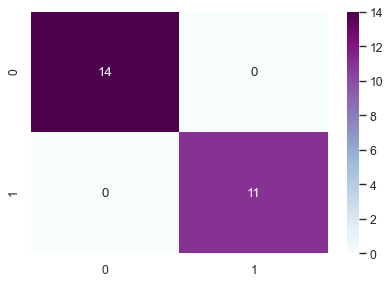

In [40]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set()
# fig = plt.figure()
plt.figure(dpi=80)
# ax = fig.add_subplot(111)
conf_mat = c_matrix
sns.heatmap(conf_mat, annot=True, cmap="BuPu")
# ax.set_title('confusion matrix') 
# ax.set_xlabel('predict') 
# ax.set_ylabel('true') 
plt.show()

In [41]:
print(context)


===== Operation Usage (in single thread) =====
            TIME_UNIT  NUM_USAGE    TIME_USAGE
encrypt         0.370   750409.0  2.776513e+05
mult_const      0.121  3163164.0  3.827428e+05
add             0.023  3000100.0  6.900230e+04
sub_const       0.013        1.0  1.300000e-02
mult            1.000  3880444.0  3.880444e+06
decrypt         0.084   750030.0  6.300252e+04
sub             0.023  3913084.0  9.000093e+04
bootstrap     114.898  2999976.0  3.446912e+08
----------------------------------------------
	*** Total estimated time unit : 349454086.387
	*** Max level down            : 29
	*** Use parameter preset      : (17, 29, 51, 3)



- **OP_TYPE**：Type of operation unit used in algorithm
- **TIME_UNIT**：Time consumed on operation unit
- **NUM_USAGE**： The number of each OP_TYPE used in algorithm
- **TIME_USAGE**：Total estimated time of operation unit

In [42]:
print(classification_report(label_test, dec_out_))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        14
           1       1.00      1.00      1.00        11

    accuracy                           1.00        25
   macro avg       1.00      1.00      1.00        25
weighted avg       1.00      1.00      1.00        25



- **Precision**: Precision (also called positive predictive value) is the fraction of relevant instances among the retrieved instances
- **Recall**: recall (also known as sensitivity) is the fraction of relevant instances that were retrieved
- **f1-score**: The F-score, also called the F1-score, is a measure of a model's accuracy on a dataset

In [43]:
from sklearn import svm

In [44]:
model=svm.SVC()
model.fit(data_train,label_train)
r = model.predict(data_test)
c = confusion_matrix(label_test, r)
c

array([[14,  0],
       [ 0, 11]])

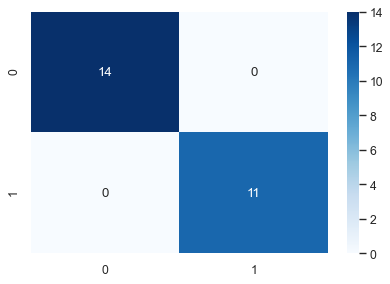

In [45]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set()
# fig = plt.figure()
plt.figure(dpi=80)
# ax = fig.add_subplot(111)
conf_mat = c
sns.heatmap(conf_mat, annot=True, cmap="Blues")
# ax.set_title('confusion matrix') 
# ax.set_xlabel('predict') 
# ax.set_ylabel('true') 
plt.show()

In [46]:
print(classification_report(label_test, r))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        14
           1       1.00      1.00      1.00        11

    accuracy                           1.00        25
   macro avg       1.00      1.00      1.00        25
weighted avg       1.00      1.00      1.00        25

